# Enhancing Emotion Recognition Using POS Tagging 
### Assignment 1 : [NLP: CS60075](https://sites.google.com/view/nlp-cs-iit-kgp/assignments)
#### Autumn Semester 2024, IIT Kharagpur
Hardik Soni 20CS30023 


In [1]:
!pip install nltk datasets tqdm scikit-learn seaborn

In [2]:
# Import libraries
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random, time
from tqdm import tqdm
from datasets import load_dataset
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from nltk.corpus import treebank
from nltk.tokenize import sent_tokenize, word_tokenize
# Suppress warnings
warnings.filterwarnings("ignore")
random.seed(42)

In [3]:
nltk.download('treebank')

[nltk_data] Downloading package treebank to /usr/share/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

# Task 1: Implement part-of-speech (POS) Tagger

In [4]:
# Load the tagged sentences
tagged_sentences = list(treebank.tagged_sents(tagset='universal'))
tagged_sentences[:1]

[[('Pierre', 'NOUN'),
  ('Vinken', 'NOUN'),
  (',', '.'),
  ('61', 'NUM'),
  ('years', 'NOUN'),
  ('old', 'ADJ'),
  (',', '.'),
  ('will', 'VERB'),
  ('join', 'VERB'),
  ('the', 'DET'),
  ('board', 'NOUN'),
  ('as', 'ADP'),
  ('a', 'DET'),
  ('nonexecutive', 'ADJ'),
  ('director', 'NOUN'),
  ('Nov.', 'NOUN'),
  ('29', 'NUM'),
  ('.', '.')]]

In [5]:
# Splitting data into training and validation set in the ratio 95:5
train_set, test_set = train_test_split(tagged_sentences, train_size=0.95, test_size=0.05)

print("Training Set Length -", len(train_set))
print("Testing Set Length -", len(test_set))
print("-" * 150)
print("Training Data -\n")
print(train_set[:5])

Training Set Length - 3718
Testing Set Length - 196
------------------------------------------------------------------------------------------------------------------------------------------------------
Training Data -

[[('But', 'CONJ'), ('the', 'DET'), ('prospects', 'NOUN'), ('for', 'ADP'), ('legislation', 'NOUN'), ('that', 'DET'), ('*T*-1', 'X'), ('targets', 'VERB'), ('program', 'NOUN'), ('trading', 'NOUN'), ('is', 'VERB'), ('unlikely', 'ADJ'), ('anytime', 'ADV'), ('soon', 'ADV'), ('.', '.')], [('They', 'PRON'), ('suffered', 'VERB'), ('from', 'ADP'), ('malnutrition', 'NOUN'), (',', '.'), ('chest', 'NOUN'), ('diseases', 'NOUN'), (',', '.'), ('cardiovascular', 'ADJ'), ('disorders', 'NOUN'), (',', '.'), ('skin', 'NOUN'), ('problems', 'NOUN'), (',', '.'), ('infectious', 'ADJ'), ('diseases', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('aftereffects', 'NOUN'), ('of', 'ADP'), ('assaults', 'NOUN'), ('and', 'CONJ'), ('rape', 'NOUN'), ('.', '.')], [('Among', 'ADP'), ('other', 'ADJ'), ('banking

In [6]:
# Getting list of train and test tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
print("Train Tagged Words - ", len(train_tagged_words))

test_tagged_words = [tup[0] for sent in test_set for tup in sent]
print("Train Tagged Words - ", len(test_tagged_words))

Train Tagged Words -  95786
Train Tagged Words -  4890


In [7]:
# Let's have a look at the tagged words in the training set
train_tagged_words[:10]

[('But', 'CONJ'),
 ('the', 'DET'),
 ('prospects', 'NOUN'),
 ('for', 'ADP'),
 ('legislation', 'NOUN'),
 ('that', 'DET'),
 ('*T*-1', 'X'),
 ('targets', 'VERB'),
 ('program', 'NOUN'),
 ('trading', 'NOUN')]

In [8]:
# Building the training vocabulary set (unique words)
training_vocabulary_set = set([token[0] for token in train_tagged_words])

# Building the POS tags set (unique tags)
training_pos_tag_set = set([token[1] for token in train_tagged_words])

# Checking the number of unique tags in the training data
print("Number of unique POS tags in the training set:", len(training_pos_tag_set))
print("Unique POS tags:", training_pos_tag_set)
# let's check how many words are present in vocabulary
print("Number of words present in vocabulary: ", len(training_vocabulary_set))

Number of unique POS tags in the training set: 12
Unique POS tags: {'CONJ', 'ADV', 'NUM', 'DET', 'ADJ', 'PRON', '.', 'ADP', 'NOUN', 'VERB', 'X', 'PRT'}
Number of words present in vocabulary:  12104


### Building the Viterbi based POS Tagger

In [9]:
# compute emission probability for a given word for a given tag
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1] == tag]
    tag_count = len(tag_list)    
    word_given_tag_list = [pair[0] for pair in tag_list if pair[0] == word]    
    word_given_tag_count = len(word_given_tag_list)    
    return (word_given_tag_count, tag_count)

# compute transition probabilities of a previous and next tag
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    
    t1_tags_list = [tag for tag in tags if tag == t1]
    t1_tags_count = len(t1_tags_list)
    
    t2_given_t1_list = [tags[index+1] for index in range(len(tags)-1) if tags[index] == t1 and tags[index+1] == t2]
    t2_given_t1_count = len(t2_given_t1_list)
    
    return(t2_given_t1_count, t1_tags_count)

# computing P(w/t) and storing in [Tags x Vocabulary] matrix. This is a matrix with dimension
# of len(training_pos_tag_set) X en(training_vocabulary_set)

len_pos_tags = len(training_pos_tag_set)
len_vocab = len(training_vocabulary_set)

# creating t x t transition matrix of training_pos_tag_set
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len_pos_tags, len_pos_tags), dtype='float32')
for i, t1 in enumerate(list(training_pos_tag_set)):
    for j, t2 in enumerate(list(training_pos_tag_set)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
        
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(training_pos_tag_set), index=list(training_pos_tag_set))
tags_df

,CONJ,ADV,NUM,DET,ADJ,PRON,.,ADP,NOUN,VERB,X,PRT
CONJ,0.000462,0.055889,0.040185,0.120554,0.119169,0.056813,0.036028,0.051732,0.348268,0.157506,0.008314,0.005081
ADV,0.007258,0.080501,0.030683,0.068624,0.128670,0.015506,0.137908,0.117453,0.031673,0.344111,0.024084,0.013527
NUM,0.013585,0.002953,0.185174,0.003249,0.033668,0.001477,0.115475,0.035145,0.352924,0.018015,0.211459,0.026875
DET,0.000481,0.012495,0.022468,0.005527,0.206536,0.003725,0.017662,0.009011,0.636790,0.038808,0.046257,0.000240
ADJ,0.017052,0.004755,0.020495,0.005083,0.067880,0.000656,0.065257,0.077390,0.698967,0.011313,0.020659,0.010494
PRON,0.005395,0.034682,0.007707,0.009249,0.072447,0.006936,0.039692,0.022736,0.210019,0.485164,0.093256,0.012717
.,0.058024,0.052392,0.081270,0.173894,0.043719,0.065087,0.093965,0.091104,0.222083,0.088333,0.027716,0.002325
ADP,0.000856,0.013800,0.062794,0.324561,0.105156,0.068999,0.040436,0.017009,0.322101,0.008237,0.034660,0.001391
NOUN,0.042677,0.016896,0.009686,0.013510,0.012017,0.004734,0.240441,0.176826,0.264547,0.146348,0.028585,0.043733
VERB,0.005439,0.082524,0.023001,0.135597,0.065506,0.035900,0.034812,0.090528,0.110110,0.168389,0.217033,0.031160


### Viterbi Algorithm
The steps are as follows:

1. Given a sequence of words.
2. Iterate through the sequence
3. For each word (starting from first word in sequence) calculate the product of emission probabilties and transition probabilties for all possible tags.
4. Assign the tag which has maximum probability obtained in step 3 above.
5. Move to the next word in sequence to repeat steps 3 and 4 above.

In [10]:
class ViterbiTagger:
    def __init__(self):
        self.start_token = '<s>'
        self.end_token = '</s>'
        self.tags = []
        self.emission_probabilities = defaultdict(lambda: defaultdict(float))
        self.transition_probabilities = defaultdict(lambda: defaultdict(float))
        self.tag_frequencies = defaultdict(float)
        self.smoothing_factor = 1e-5  # Smoothing constant to handle zero probabilities
        self.vocabulary = set()

    def fit(self, training_data):
        """
        Train the Viterbi Tagger using the provided training data.
        
        :param training_data: List of tagged sentences (List of (word, tag) pairs)
        """
        for sentence in training_data:
            previous_tag = self.start_token
            for word, tag in sentence:
                self.emission_probabilities[tag][word] += 1
                self.transition_probabilities[previous_tag][tag] += 1
                self.tag_frequencies[tag] += 1
                previous_tag = tag
                self.vocabulary.add(word)
            self.transition_probabilities[previous_tag][self.end_token] += 1

        # Normalize emission and transition probabilities with smoothing
        vocab_size = len(self.vocabulary)
        tag_count = len(self.tag_frequencies)
        
        for tag in self.emission_probabilities:
            for word in self.emission_probabilities[tag]:
                count = self.emission_probabilities[tag][word]
                self.emission_probabilities[tag][word] = (count + self.smoothing_factor) / (self.tag_frequencies[tag] + self.smoothing_factor * vocab_size)

        for prev_tag in self.transition_probabilities:
            for tag in self.transition_probabilities[prev_tag]:
                count = self.transition_probabilities[prev_tag][tag]
                self.transition_probabilities[prev_tag][tag] = (count + self.smoothing_factor) / (self.tag_frequencies[tag] + self.smoothing_factor * tag_count)

        self.tags = list(self.tag_frequencies.keys())

    def predict(self, sentence):
        """
        Predict the most likely sequence of tags for the given sentence using the Viterbi algorithm.
        
        :param sentence: List of words in the sentence
        :return: List of predicted tags
        """
        viterbi_matrix = [{}]
        backpointers = {}
        
        # Initialization for the first word
        for tag in self.tags:
            viterbi_matrix[0][tag] = (
                self.transition_probabilities[self.start_token].get(tag, 0) *
                self.emission_probabilities[tag].get(sentence[0], 0)
            )
            backpointers[tag] = [tag]
        
        # Dynamic programming step
        for t in range(1, len(sentence)):
            viterbi_matrix.append({})
            new_backpointers = {}
            
            for tag in self.tags:
                max_prob, best_tag = max(
                    (viterbi_matrix[t - 1][prev_tag] * 
                     self.transition_probabilities[prev_tag].get(tag, 0) * 
                     self.emission_probabilities[tag].get(sentence[t], 0), prev_tag)
                    for prev_tag in self.tags
                )
                
                if max_prob == 0:
                    max_prob, best_tag = max(
                        (self.transition_probabilities[prev_tag].get(tag, 0), prev_tag)
                        for prev_tag in self.tags
                    )
                
                viterbi_matrix[t][tag] = max_prob
                new_backpointers[tag] = backpointers[best_tag] + [tag]
            
            backpointers = new_backpointers
        
        # Termination step to get the best path
        final_max_prob, final_best_tag = max(
            (viterbi_matrix[-1][tag] * self.transition_probabilities[tag].get(self.end_token, 0), tag)
            for tag in self.tags
        )
        
        return backpointers[final_best_tag]


In [11]:
pos_tagger = ViterbiTagger()
pos_tagger.fit(treebank.tagged_sents())

In [12]:
sent = "Random sampling for training helps create diverse datasets, improving the NLP model's ability to handle various linguistic patterns."
# sent = "Setting random seeds in NLP experiments ensures reproducibility and allows others to verify results."
# sent = "Shuffling sentences or words in data preparation reduces bias and helps NLP models generalize better to new data."
tokens = word_tokenize(sent)
print('Word-Tokens: ',tokens, "\n")
print(list(zip(tokens, pos_tagger.predict(tokens))))

Word-Tokens:  ['Random', 'sampling', 'for', 'training', 'helps', 'create', 'diverse', 'datasets', ',', 'improving', 'the', 'NLP', 'model', "'s", 'ability', 'to', 'handle', 'various', 'linguistic', 'patterns', '.'] 

[('Random', 'DT'), ('sampling', 'NN'), ('for', 'IN'), ('training', 'DT'), ('helps', 'NN'), ('create', 'IN'), ('diverse', 'DT'), ('datasets', 'NN'), (',', 'IN'), ('improving', 'DT'), ('the', 'NN'), ('NLP', 'IN'), ('model', 'DT'), ("'s", 'NN'), ('ability', 'IN'), ('to', 'DT'), ('handle', 'NN'), ('various', 'IN'), ('linguistic', 'DT'), ('patterns', 'NN'), ('.', '.')]


# Task 2: Vanilla Emotion Classifier

In [13]:
ds = load_dataset("dair-ai/emotion", "split")
ds
# Use the predefined splits
train_dataset = ds['train']
validation_dataset = ds['validation']
test_dataset = ds['test']
print(ds['train'][:10])

# Combine training and validation datasets
X_train = ds['train']['text'] + ds['validation']['text']
y_train = ds['train']['label'] + ds['validation']['label']

# Extract test data
X_test = ds['test']['text']
y_test = ds['test']['label']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy', 'ive been feeling a little burdened lately wasnt sure why that was', 'ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny', 'i feel as confused about life as a teenager or as jaded as a year old man', 'i have been with petronas for years i feel that petronas has performed well and made a huge profit', 'i feel romantic too'], 'label': [0, 0, 3, 2, 3, 0, 5, 4, 1, 2]}


## Support Vector Classifier (SVC)

In [14]:
# Initialize and train the SVM classifier
print("Fitting Training Data on Support Vector Classifier with Linear Kernel ......")
svm_classifier = SVC(kernel='linear')
svm_classifier.fit(X_train_tfidf, y_train)
print("Training Done!")

Fitting Training Data on Support Vector Classifier with Linear Kernel ......
Training Done!


In [15]:
# Test the model with tqdm to track time
print("Testing Classification on Test Set.....")
start_time = time.time()
y_pred_test_svc = svm_classifier.predict(X_test_tfidf)
test_time = time.time() - start_time
print(f"Testing Time: {test_time:.2f} seconds")
svc_accuracy = 100 * accuracy_score(y_test, y_pred_test_svc)
print("Test Accuracy:", svc_accuracy, "%.")
print("\nTest Report:\n", classification_report(y_test, y_pred_test_svc, target_names=ds['train'].features['label'].names))

Testing Classification on Test Set.....
Testing Time: 3.62 seconds
Test Accuracy: 88.64999999999999 %.

Test Report:
               precision    recall  f1-score   support

     sadness       0.92      0.92      0.92       581
         joy       0.89      0.94      0.91       695
        love       0.81      0.71      0.76       159
       anger       0.90      0.88      0.89       275
        fear       0.86      0.85      0.85       224
    surprise       0.73      0.55      0.63        66

    accuracy                           0.89      2000
   macro avg       0.85      0.81      0.83      2000
weighted avg       0.88      0.89      0.88      2000



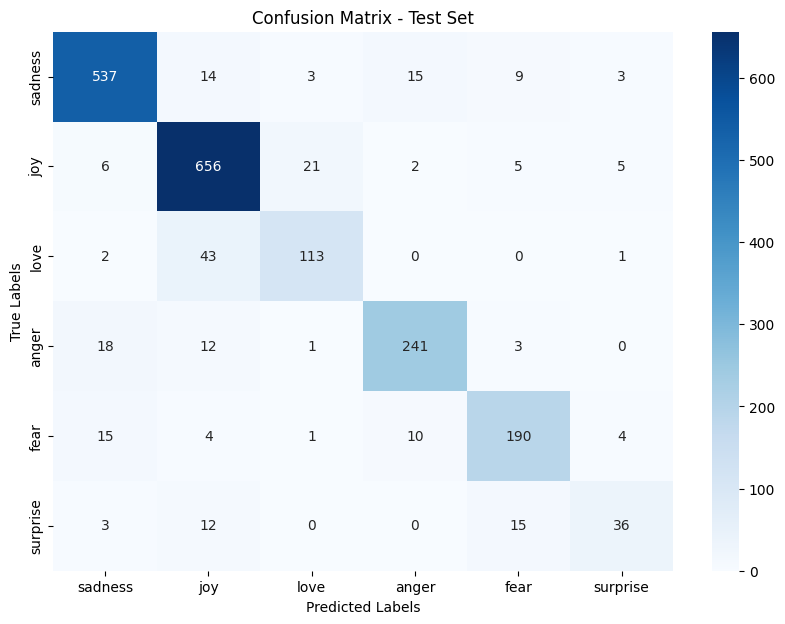

In [16]:
# Plot the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, y_pred_test_svc)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=ds['train'].features['label'].names, yticklabels=ds['train'].features['label'].names)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Task 3: Improved Emotion Recogniser (POS + Tf-idf)

In [17]:
X_train = ds['train']['text']+ds['validation']['text']
y_train = ds['train']['label']+ds['validation']['label']

X_test = ds['test']['text']
y_test = ds['test']['label']

In [18]:
class POSTfidfVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, pos_tagger=None):
        """
        Initialize with a POS tagger and a TF-IDF vectorizer
        
        Args:
            pos_tagger: POS tagger model to be used for tagging tokens
            tfidf_vectorizer: TF-IDF vectorizer for transforming documents
        """
        self.pos_tagger = pos_tagger 
        self.tfidf_vectorizer = TfidfVectorizer()

    def fit(self, documents, y=None):
        """
        Fit the POS-weighted TF-IDF vectorizer to the provided documents.

        Args:
            documents (list of str): The input text data to fit the model on.
            y: Ignored, present for compatibility with scikit-learn API.

        Returns:
            self: Returns the fitted POSTfidfVectorizer instance.
        """
        # Apply POS tagging and generate POS-weighted tokens for each document
        pos_weighted_documents = [" ".join(self._apply_pos_tags(doc)) for doc in documents]

        # Fit the TF-IDF vectorizer on the POS-weighted documents
        self.tfidf_vectorizer.fit(pos_weighted_documents)
        return self

    def transform(self, documents):
        """
        Transform the provided documents into TF-IDF weighted vectors using POS tags.

        Args:
            documents (list of str): The input text data to transform.

        Returns:
            sparse matrix: TF-IDF weighted feature matrix with POS information.
        """
        # Apply POS tagging and generate POS-weighted tokens for each document
        pos_weighted_documents = [" ".join(self._apply_pos_tags(doc)) for doc in documents]

        # Transform the POS-weighted documents into TF-IDF vectors
        return self.tfidf_vectorizer.transform(pos_weighted_documents)

    def _apply_pos_tags(self, document):
        """
        Apply POS tagging to the tokens of a document and append the POS tag to each token.

        Args:
            document (str): The input text document.

        Returns:
            list of str: List of tokens with their corresponding POS tags appended.
        """
        # Tokenize the document into individual words/tokens
        tokens = nltk.word_tokenize(document)

        # Use the POS tagger to predict POS tags for each token
        pos_tags = self.pos_tagger.predict(tokens)

        # Combine each token with its corresponding POS tag
        return [f"{token}/{tag}" for token, tag in zip(tokens, pos_tags)]

In [19]:
# Define pipeline of POSWeightedTfidf which uses the POS_Tagger from task 1
pipeline = Pipeline([
    ('pos_tfidf', POSTfidfVectorizer(pos_tagger=pos_tagger)),
    ('classifier', SVC(kernel='linear'))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('pos_tfidf',
                 POSTfidfVectorizer(pos_tagger=<__main__.ViterbiTagger object at 0x79c02156c160>)),
                ('classifier', SVC(kernel='linear'))])

In [20]:
# Predict on the test set
pred_y = pipeline.predict(X_test)

# Calculate and print the accuracy
accuracy = 100 * pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy:.3f}%")

# Print the classification report
print("Classification Report:\n", classification_report(y_test, pred_y))


Accuracy: 87.950%
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92       581
           1       0.86      0.95      0.91       695
           2       0.83      0.65      0.73       159
           3       0.90      0.87      0.88       275
           4       0.86      0.83      0.85       224
           5       0.78      0.53      0.63        66

    accuracy                           0.88      2000
   macro avg       0.86      0.79      0.82      2000
weighted avg       0.88      0.88      0.88      2000



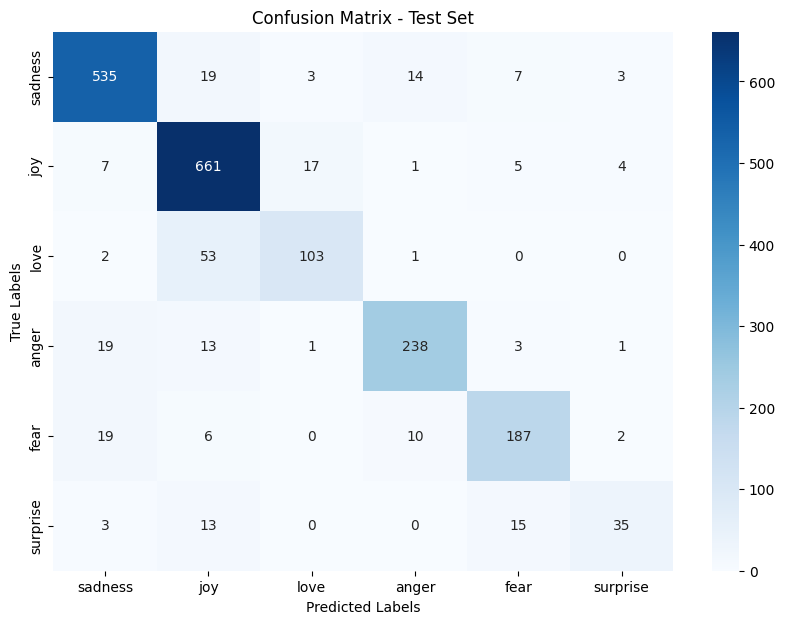

In [21]:
# Plot the confusion matrix for the test set
conf_matrix_test = confusion_matrix(y_test, pred_y)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', xticklabels=ds['train'].features['label'].names, yticklabels=ds['train'].features['label'].names)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()